## Librerías

In [73]:
import pandas as pd
import numpy as np
import os
from functools import reduce
from datetime import date,datetime
from dateutil.relativedelta import relativedelta as rd

from scipy.stats import ks_2samp

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.linear_model import Perceptron,PassiveAggressiveClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

import matplotlib.pyplot as plt
import seaborn as sns
import pygal

pd.set_option('display.max_columns',500)

## Lectura de datos

In [2]:
ruta = '/home/jose/Documentos/bd/ecobici/'

In [3]:
l = os.listdir(ruta)
l.sort()

In [4]:
l

['2017-11.csv',
 '2017-12.csv',
 '2018-01.csv',
 '2018-02.csv',
 '2018-03.csv',
 '2018-04.csv',
 '2018-05.csv',
 '2018-06.csv',
 '2018-07.csv',
 '2018-08.csv',
 '2018-09.csv',
 '2018-10.csv',
 '2018-11.csv',
 '2018-12.csv',
 '2019-01.csv',
 '2019-02.csv',
 '2019-03.csv',
 '2019-04.csv',
 '2019-05.csv',
 '2019-06.csv',
 '2019-07.csv',
 '2019-08.csv',
 '2019-09.csv',
 '2019-10.csv',
 'estaciones-de-ecobici.csv']

### Muestra

In [5]:
df = pd.concat(map(lambda arch:pd.read_csv(os.path.join(ruta,arch),usecols=['Ciclo_Estacion_Retiro']).drop_duplicates(),
                   l[:-1]),
               ignore_index=True).drop_duplicates().reset_index(drop=True)

In [6]:
cat = df.sample(n=100).reset_index(drop=True)

In [7]:
df = pd.concat(map(lambda arch:pd.read_csv(os.path.join(ruta,arch)).merge(cat,on='Ciclo_Estacion_Retiro',how='inner'),
                   l[:-1]),ignore_index=True)

/home/jose/entornos/ins/lib/python3.6/site-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  
/home/jose/entornos/ins/lib/python3.6/site-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (2,6,9) have mixed types.Specify dtype option on import or set low_memory=False.
  


In [8]:
df.shape

(3422199, 10)

## Catálogo de ventanas de tiempo

In [9]:
df['semana'] = pd.to_datetime(df['Fecha_Retiro']).map(lambda x:x.year*100+int(x.strftime('%U')))

In [10]:
df.tail()

,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,Hora_Retiro,Ciclo_Estacion_Arribo,Fecha_Arribo,Hora_Arribo,Unnamed: 9,semana
3422194,M,33,10541,443,31/10/2019,18:50:41,321,31/10/2019,19:11:04,NaN,201943
3422195,M,42,8601,443,31/10/2019,19:55:35,425,31/10/2019,20:02:58,NaN,201943
3422196,M,27,9016,443,31/10/2019,21:13:34,427,31/10/2019,21:19:49,NaN,201943
3422197,M,28,6780,443,31/10/2019,21:37:18,427,31/10/2019,21:41:50,NaN,201943
3422198,M,32,11008,443,31/10/2019,23:22:05,402,31/10/2019,23:29:44,NaN,201943


In [11]:
catfh = df[['semana']].drop_duplicates().sort_values('semana',ascending=True).reset_index(drop=True)

In [12]:
catfh['id_semana'] = catfh.index+1

In [13]:
df = df.merge(catfh,on='semana',how='inner')

In [14]:
df.drop('semana',axis=1,inplace=True)
df.drop('Unnamed: 9',axis=1,inplace=True)

In [15]:
df.head()

,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,Hora_Retiro,Ciclo_Estacion_Arribo,Fecha_Arribo,Hora_Arribo,id_semana
0,M,35,8106,359,01/11/2017,0:02:16,338,01/11/2017,0:05:54,1
1,M,26,10324,359,01/11/2017,0:11:01,357,01/11/2017,0:13:54,1
2,M,60,4087,359,01/11/2017,5:09:26,425,01/11/2017,5:18:07,1
3,M,41,7052,359,01/11/2017,6:04:26,341,01/11/2017,6:07:52,1
4,F,32,4269,359,01/11/2017,6:25:45,361,01/11/2017,6:34:41,1


## Ingeniería de datos

In [16]:
semi,semf = df[['id_semana']].describe().T[['min','max']].values[0].tolist()
semi,semf

(1.0, 123.0)

In [17]:
vobs = 12
vdes = 1
anclai = int(semi)+vobs-1
anclaf = int(semf)-vdes
anclai,anclaf

(12, 122)

In [18]:
um = ['Ciclo_Estacion_Retiro','ancla']

In [19]:
ancla = 12
step = 3

In [82]:
varc = ['Edad_Usuario','n']
vard = ['Genero_Usuario','hora']

In [83]:
def trans(df,ancla,k):
    print(ancla,k)
    aux = df.loc[(df['id_semana']>=(ancla-k+1))&(df['id_semana']<=ancla)].reset_index(drop=True)
    aux = aux[['id_semana','Genero_Usuario','Edad_Usuario','Hora_Retiro','Ciclo_Estacion_Retiro']]
    aux['hora'] =aux['Hora_Retiro'].map(lambda x:int(x.split(':')[0])//6).astype(str)
    aux.drop('Hora_Retiro',axis=1,inplace=True)
    aux['n'] = 1
    
    t = aux.copy()
    
    for v in vard:
        t[v] = 'total_%s'%v
    aux = pd.concat([aux,t],ignore_index=True)
    
    def piv(aux,v,ancla):
        aux = aux.pivot_table(index='Ciclo_Estacion_Retiro',
                        columns=v,
                        values=varc,
                        aggfunc=['min','max','mean','sum','std'])
        aux.columns = ["v_%s_"%v+"_".join(x)+"_%d"%k for x in aux.columns]
        return aux.reset_index().assign(ancla=ancla)
    
    aux = reduce(lambda x,y:pd.merge(x,y,on=um,how='outer'),map(lambda v:piv(aux,v,ancla),vard))
    return aux

### Espacio de predictoras (características) $\mathcal{X}$

In [84]:
X = pd.concat(map(lambda ancla:reduce(lambda x,y:pd.merge(x,y,on=um,how='outer'),
       map(lambda k:trans(df,ancla,k),range(step,vobs+step,step))),range(anclai,anclaf+1)),ignore_index=True)

12 3
12 6
12 9
12 12
13 3
13 6
13 9
13 12
14 3
14 6
14 9
14 12
15 3
15 6
15 9
15 12
16 3
16 6
16 9
16 12
17 3
17 6
17 9
17 12
18 3
18 6
18 9
18 12
19 3
19 6
19 9
19 12
20 3
20 6
20 9
20 12
21 3
21 6
21 9
21 12
22 3
22 6
22 9
22 12
23 3
23 6
23 9
23 12
24 3
24 6
24 9
24 12
25 3
25 6
25 9
25 12
26 3
26 6
26 9
26 12
27 3
27 6
27 9
27 12
28 3
28 6
28 9
28 12
29 3
29 6
29 9
29 12
30 3
30 6
30 9
30 12
31 3
31 6
31 9
31 12
32 3
32 6
32 9
32 12
33 3
33 6
33 9
33 12
34 3
34 6
34 9
34 12
35 3
35 6
35 9
35 12
36 3
36 6
36 9
36 12
37 3
37 6
37 9
37 12
38 3
38 6
38 9
38 12
39 3
39 6
39 9
39 12
40 3
40 6
40 9
40 12
41 3
41 6
41 9
41 12
42 3
42 6
42 9
42 12
43 3
43 6
43 9
43 12
44 3
44 6
44 9
44 12
45 3
45 6
45 9
45 12
46 3
46 6
46 9
46 12
47 3
47 6
47 9
47 12
48 3
48 6
48 9
48 12
49 3
49 6
49 9
49 12
50 3
50 6
50 9
50 12
51 3
51 6
51 9
51 12
52 3
52 6
52 9
52 12
53 3
53 6
53 9
53 12
54 3
54 6
54 9
54 12
55 3
55 6
55 9
55 12
56 3
56 6
56 9
56 12
57 3
57 6
57 9
57 12
58 3
58 6
58 9
58 12
59 3
59 6
59 

In [85]:
X.head()

,Ciclo_Estacion_Retiro,v_Genero_Usuario_min_Edad_Usuario_F_3,v_Genero_Usuario_min_Edad_Usuario_M_3,v_Genero_Usuario_min_Edad_Usuario_total_Genero_Usuario_3,v_Genero_Usuario_min_n_F_3,v_Genero_Usuario_min_n_M_3,v_Genero_Usuario_min_n_total_Genero_Usuario_3,v_Genero_Usuario_max_Edad_Usuario_F_3,v_Genero_Usuario_max_Edad_Usuario_M_3,v_Genero_Usuario_max_Edad_Usuario_total_Genero_Usuario_3,v_Genero_Usuario_max_n_F_3,v_Genero_Usuario_max_n_M_3,v_Genero_Usuario_max_n_total_Genero_Usuario_3,v_Genero_Usuario_mean_Edad_Usuario_F_3,v_Genero_Usuario_mean_Edad_Usuario_M_3,v_Genero_Usuario_mean_Edad_Usuario_total_Genero_Usuario_3,v_Genero_Usuario_mean_n_F_3,v_Genero_Usuario_mean_n_M_3,v_Genero_Usuario_mean_n_total_Genero_Usuario_3,v_Genero_Usuario_sum_Edad_Usuario_F_3,v_Genero_Usuario_sum_Edad_Usuario_M_3,v_Genero_Usuario_sum_Edad_Usuario_total_Genero_Usuario_3,v_Genero_Usuario_sum_n_F_3,v_Genero_Usuario_sum_n_M_3,v_Genero_Usuario_sum_n_total_Genero_Usuario_3,v_Genero_Usuario_std_Edad_Usuario_F_3,v_Genero_Usuario_std_Edad_Usuario_M_3,v_Genero_Usuario_std_Edad_Usuario_total_Genero_Usuario_3,v_Genero_Usuario_std_n_F_3,v_Genero_Usuario_std_n_M_3,v_Genero_Usuario_std_n_total_Genero_Usuario_3,ancla,v_hora_min_Edad_Usuario_0_3,v_hora_min_Edad_Usuario_1_3,v_hora_min_Edad_Usuario_2_3,v_hora_min_Edad_Usuario_3_3,v_hora_min_Edad_Usuario_total_hora_3,v_hora_min_n_0_3,v_hora_min_n_1_3,v_hora_min_n_2_3,v_hora_min_n_3_3,v_hora_min_n_total_hora_3,v_hora_max_Edad_Usuario_0_3,v_hora_max_Edad_Usuario_1_3,v_hora_max_Edad_Usuario_2_3,v_hora_max_Edad_Usuario_3_3,v_hora_max_Edad_Usuario_total_hora_3,v_hora_max_n_0_3,v_hora_max_n_1_3,v_hora_max_n_2_3,v_hora_max_n_3_3,v_hora_max_n_total_hora_3,v_hora_mean_Edad_Usuario_0_3,v_hora_mean_Edad_Usuario_1_3,v_hora_mean_Edad_Usuario_2_3,v_hora_mean_Edad_Usuario_3_3,v_hora_mean_Edad_Usuario_total_hora_3,v_hora_mean_n_0_3,v_hora_mean_n_1_3,v_hora_mean_n_2_3,v_hora_mean_n_3_3,v_hora_mean_n_total_hora_3,v_hora_sum_Edad_Usuario_0_3,v_hora_sum_Edad_Usuario_1_3,v_hora_sum_Edad_Usuario_2_3,v_hora_sum_Edad_Usuario_3_3,v_hora_sum_Edad_Usuario_total_hora_3,v_hora_sum_n_0_3,v_hora_sum_n_1_3,v_hora_sum_n_2_3,v_hora_sum_n_3_3,v_hora_sum_n_total_hora_3,v_hora_std_Edad_Usuario_0_3,v_hora_std_Edad_Usuario_1_3,v_hora_std_Edad_Usuario_2_3,v_hora_std_Edad_Usuario_3_3,v_hora_std_Edad_Usuario_total_hora_3,v_hora_std_n_0_3,v_hora_std_n_1_3,v_hora_std_n_2_3,v_hora_std_n_3_3,v_hora_std_n_total_hora_3,v_Genero_Usuario_min_Edad_Usuario_F_6,v_Genero_Usuario_min_Edad_Usuario_M_6,v_Genero_Usuario_min_Edad_Usuario_total_Genero_Usuario_6,v_Genero_Usuario_min_n_F_6,v_Genero_Usuario_min_n_M_6,v_Genero_Usuario_min_n_total_Genero_Usuario_6,v_Genero_Usuario_max_Edad_Usuario_F_6,v_Genero_Usuario_max_Edad_Usuario_M_6,v_Genero_Usuario_max_Edad_Usuario_total_Genero_Usuario_6,v_Genero_Usuario_max_n_F_6,v_Genero_Usuario_max_n_M_6,v_Genero_Usuario_max_n_total_Genero_Usuario_6,v_Genero_Usuario_mean_Edad_Usuario_F_6,v_Genero_Usuario_mean_Edad_Usuario_M_6,v_Genero_Usuario_mean_Edad_Usuario_total_Genero_Usuario_6,v_Genero_Usuario_mean_n_F_6,v_Genero_Usuario_mean_n_M_6,v_Genero_Usuario_mean_n_total_Genero_Usuario_6,v_Genero_Usuario_sum_Edad_Usuario_F_6,v_Genero_Usuario_sum_Edad_Usuario_M_6,v_Genero_Usuario_sum_Edad_Usuario_total_Genero_Usuario_6,v_Genero_Usuario_sum_n_F_6,v_Genero_Usuario_sum_n_M_6,v_Genero_Usuario_sum_n_total_Genero_Usuario_6,v_Genero_Usuario_std_Edad_Usuario_F_6,v_Genero_Usuario_std_Edad_Usuario_M_6,v_Genero_Usuario_std_Edad_Usuario_total_Genero_Usuario_6,v_Genero_Usuario_std_n_F_6,v_Genero_Usuario_std_n_M_6,v_Genero_Usuario_std_n_total_Genero_Usuario_6,v_hora_min_Edad_Usuario_0_6,v_hora_min_Edad_Usuario_1_6,v_hora_min_Edad_Usuario_2_6,v_hora_min_Edad_Usuario_3_6,v_hora_min_Edad_Usuario_total_hora_6,v_hora_min_n_0_6,v_hora_min_n_1_6,v_hora_min_n_2_6,v_hora_min_n_3_6,v_hora_min_n_total_hora_6,v_hora_max_Edad_Usuario_0_6,v_hora_max_Edad_Usuario_1_6,v_hora_max_Edad_Usuario_2_6,v_hora_max_Edad_Usuario_3_6,v_hora_max_Edad_Usuario_total_hora_6,v_hora_max_n

In [87]:
def target(df,ancla,vdes):
    aux = df.loc[(df['id_semana']>ancla)&(df['id_semana']<=(ancla+vdes))].reset_index(drop=True).copy()[um[:1]].assign(y=1)
    aux = aux.groupby(um[0]).sum()
    return aux.assign(ancla=ancla).reset_index()

In [88]:
y= pd.concat(map(lambda ancla: target(df,ancla,vdes),range(anclai,anclaf+1)),ignore_index=True)

### Creación de TAD (Tabla analítica de datos) $\vec{y}=f(\mathcal{X})$

In [89]:
tad = X.merge(y,on=um,how='inner')

In [90]:
tad.head()

,Ciclo_Estacion_Retiro,v_Genero_Usuario_min_Edad_Usuario_F_3,v_Genero_Usuario_min_Edad_Usuario_M_3,v_Genero_Usuario_min_Edad_Usuario_total_Genero_Usuario_3,v_Genero_Usuario_min_n_F_3,v_Genero_Usuario_min_n_M_3,v_Genero_Usuario_min_n_total_Genero_Usuario_3,v_Genero_Usuario_max_Edad_Usuario_F_3,v_Genero_Usuario_max_Edad_Usuario_M_3,v_Genero_Usuario_max_Edad_Usuario_total_Genero_Usuario_3,v_Genero_Usuario_max_n_F_3,v_Genero_Usuario_max_n_M_3,v_Genero_Usuario_max_n_total_Genero_Usuario_3,v_Genero_Usuario_mean_Edad_Usuario_F_3,v_Genero_Usuario_mean_Edad_Usuario_M_3,v_Genero_Usuario_mean_Edad_Usuario_total_Genero_Usuario_3,v_Genero_Usuario_mean_n_F_3,v_Genero_Usuario_mean_n_M_3,v_Genero_Usuario_mean_n_total_Genero_Usuario_3,v_Genero_Usuario_sum_Edad_Usuario_F_3,v_Genero_Usuario_sum_Edad_Usuario_M_3,v_Genero_Usuario_sum_Edad_Usuario_total_Genero_Usuario_3,v_Genero_Usuario_sum_n_F_3,v_Genero_Usuario_sum_n_M_3,v_Genero_Usuario_sum_n_total_Genero_Usuario_3,v_Genero_Usuario_std_Edad_Usuario_F_3,v_Genero_Usuario_std_Edad_Usuario_M_3,v_Genero_Usuario_std_Edad_Usuario_total_Genero_Usuario_3,v_Genero_Usuario_std_n_F_3,v_Genero_Usuario_std_n_M_3,v_Genero_Usuario_std_n_total_Genero_Usuario_3,ancla,v_hora_min_Edad_Usuario_0_3,v_hora_min_Edad_Usuario_1_3,v_hora_min_Edad_Usuario_2_3,v_hora_min_Edad_Usuario_3_3,v_hora_min_Edad_Usuario_total_hora_3,v_hora_min_n_0_3,v_hora_min_n_1_3,v_hora_min_n_2_3,v_hora_min_n_3_3,v_hora_min_n_total_hora_3,v_hora_max_Edad_Usuario_0_3,v_hora_max_Edad_Usuario_1_3,v_hora_max_Edad_Usuario_2_3,v_hora_max_Edad_Usuario_3_3,v_hora_max_Edad_Usuario_total_hora_3,v_hora_max_n_0_3,v_hora_max_n_1_3,v_hora_max_n_2_3,v_hora_max_n_3_3,v_hora_max_n_total_hora_3,v_hora_mean_Edad_Usuario_0_3,v_hora_mean_Edad_Usuario_1_3,v_hora_mean_Edad_Usuario_2_3,v_hora_mean_Edad_Usuario_3_3,v_hora_mean_Edad_Usuario_total_hora_3,v_hora_mean_n_0_3,v_hora_mean_n_1_3,v_hora_mean_n_2_3,v_hora_mean_n_3_3,v_hora_mean_n_total_hora_3,v_hora_sum_Edad_Usuario_0_3,v_hora_sum_Edad_Usuario_1_3,v_hora_sum_Edad_Usuario_2_3,v_hora_sum_Edad_Usuario_3_3,v_hora_sum_Edad_Usuario_total_hora_3,v_hora_sum_n_0_3,v_hora_sum_n_1_3,v_hora_sum_n_2_3,v_hora_sum_n_3_3,v_hora_sum_n_total_hora_3,v_hora_std_Edad_Usuario_0_3,v_hora_std_Edad_Usuario_1_3,v_hora_std_Edad_Usuario_2_3,v_hora_std_Edad_Usuario_3_3,v_hora_std_Edad_Usuario_total_hora_3,v_hora_std_n_0_3,v_hora_std_n_1_3,v_hora_std_n_2_3,v_hora_std_n_3_3,v_hora_std_n_total_hora_3,v_Genero_Usuario_min_Edad_Usuario_F_6,v_Genero_Usuario_min_Edad_Usuario_M_6,v_Genero_Usuario_min_Edad_Usuario_total_Genero_Usuario_6,v_Genero_Usuario_min_n_F_6,v_Genero_Usuario_min_n_M_6,v_Genero_Usuario_min_n_total_Genero_Usuario_6,v_Genero_Usuario_max_Edad_Usuario_F_6,v_Genero_Usuario_max_Edad_Usuario_M_6,v_Genero_Usuario_max_Edad_Usuario_total_Genero_Usuario_6,v_Genero_Usuario_max_n_F_6,v_Genero_Usuario_max_n_M_6,v_Genero_Usuario_max_n_total_Genero_Usuario_6,v_Genero_Usuario_mean_Edad_Usuario_F_6,v_Genero_Usuario_mean_Edad_Usuario_M_6,v_Genero_Usuario_mean_Edad_Usuario_total_Genero_Usuario_6,v_Genero_Usuario_mean_n_F_6,v_Genero_Usuario_mean_n_M_6,v_Genero_Usuario_mean_n_total_Genero_Usuario_6,v_Genero_Usuario_sum_Edad_Usuario_F_6,v_Genero_Usuario_sum_Edad_Usuario_M_6,v_Genero_Usuario_sum_Edad_Usuario_total_Genero_Usuario_6,v_Genero_Usuario_sum_n_F_6,v_Genero_Usuario_sum_n_M_6,v_Genero_Usuario_sum_n_total_Genero_Usuario_6,v_Genero_Usuario_std_Edad_Usuario_F_6,v_Genero_Usuario_std_Edad_Usuario_M_6,v_Genero_Usuario_std_Edad_Usuario_total_Genero_Usuario_6,v_Genero_Usuario_std_n_F_6,v_Genero_Usuario_std_n_M_6,v_Genero_Usuario_std_n_total_Genero_Usuario_6,v_hora_min_Edad_Usuario_0_6,v_hora_min_Edad_Usuario_1_6,v_hora_min_Edad_Usuario_2_6,v_hora_min_Edad_Usuario_3_6,v_hora_min_Edad_Usuario_total_hora_6,v_hora_min_n_0_6,v_hora_min_n_1_6,v_hora_min_n_2_6,v_hora_min_n_3_6,v_hora_min_n_total_hora_6,v_hora_max_Edad_Usuario_0_6,v_hora_max_Edad_Usuario_1_6,v_hora_max_Edad_Usuario_2_6,v_hora_max_Edad_Usuario_3_6,v_hora_max_Edad_Usuario_total_hora_6,v_hora_max_n

## Análisis Exploratorio de Datos

### Selección de variables

In [91]:
varc = [v for v in tad.columns if v[:2]=='v_']
tgt = 'y'
len(varc)

320

### Valores Ausentes

### Cuantificación de porcentaje de ausentes

In [92]:
miss = 1-tad[varc].describe().T[['count']]/len(tad)

In [93]:
miss.describe()

,count
count,320.000000
mean,0.008965
std,0.027207
min,0.000000
25%,0.000539
50%,0.001171
75%,0.002342
max,0.219974


### Imputación

In [94]:
X = tad[varc].copy()

In [112]:
im = SimpleImputer(strategy='median')

In [113]:
im.fit(X)

SimpleImputer(strategy='median')

In [114]:
Xi = pd.DataFrame(im.transform(X),columns=varc)

In [115]:
#Prueba de Kolmogorov-Smirnov (Prueba de bondad de ajuste que verifica que dos distribuciones son estadísticamente iguales)k
ks = pd.DataFrame(map(lambda v: (v,ks_2samp(tad[v].dropna(),Xi[v]).statistic),varc),columns=['variable','ks'])

In [116]:
ks.loc[ks['ks']>.1]

,variable,ks
70,v_hora_std_Edad_Usuario_0_3,0.109987


### Valores Extremos

In [131]:
cotas = X.describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values.tolist()

In [136]:
def extremo(df,v,ci,cs):
    aux = df[um+[v]].copy()
    aux['ol_%s'%v] = ((aux[v]<ci)|(aux[v]>cs)).astype(int)
    return aux.drop(v,axis=1)

In [138]:
ext = reduce(lambda x,y:pd.merge(x,y,on=um,how='outer'),map(lambda z:extremo(tad,*z),cotas))

In [140]:
varol = [v for v in ext if v[:2]=='ol']

In [142]:
ext['extremo'] = ext[varol].max(axis=1)

In [144]:
ext['extremo'].describe()

count    10674.000000
mean         0.340079
std          0.473758
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: extremo, dtype: float64

## Modelación (encontrar los parámetros $\vec{\theta}$ del modelo $f$ para $\vec{y}=f(\mathcal{X}) \rightarrow y=\theta_0+\vec{\theta}\cdot \vec{x}$

In [146]:
y = tad[tgt].copy()

In [167]:
Xt,Xv,yt,yv = train_test_split(Xi,y,train_size=0.7)

In [168]:
modelo = LinearRegression()

In [169]:
hiperparametros=dict(fit_intercept=[True,False],normalize=[True,False])
hiperparametros

{'fit_intercept': [True, False], 'normalize': [True, False]}

In [172]:
grid = GridSearchCV(param_grid=hiperparametros,
                    estimator=modelo,
                    cv=10,
                    scoring='neg_mean_absolute_error',
                    n_jobs=-1,
                    verbose=True)

In [173]:
grid.fit(Xt,yt)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.5s finished


GridSearchCV(cv=10, estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]},
             scoring='neg_mean_absolute_error', verbose=True)

In [176]:
modelo = grid.best_estimator_

In [179]:
grid.best_params_

{'fit_intercept': True, 'normalize': False}

In [181]:
modelo.fit(Xt,yt)

LinearRegression()

In [185]:
modelo.intercept_

146.80459900465456

In [186]:
print(mean_absolute_error(y_true=yt,y_pred=modelo.predict(Xt)))
print(mean_absolute_error(y_true=yv,y_pred=modelo.predict(Xv)))

65.54641784284132
65.63157798192294


/home/jose/entornos/ins/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/jose/entornos/ins/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='y', ylabel='Density'>

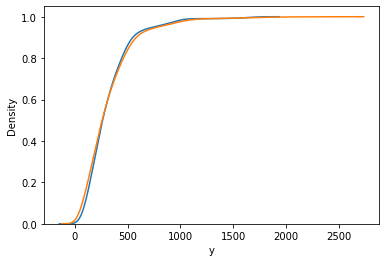

In [190]:
sns.distplot(modelo.predict(Xt),hist=False,kde_kws={'cumulative':True})
sns.distplot(yt,hist=False,kde_kws={'cumulative':True})

/home/jose/entornos/ins/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/jose/entornos/ins/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='y', ylabel='Density'>

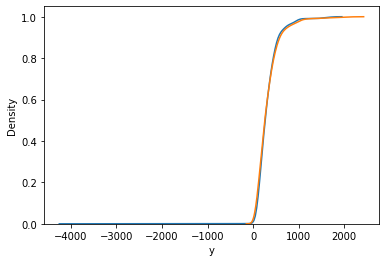

In [192]:
sns.distplot(modelo.predict(Xv),hist=False,kde_kws={'cumulative':True})
sns.distplot(yv,hist=False,kde_kws={'cumulative':True})

In [193]:
Xv['y^'] = modelo.predict(Xv)
Xv['y'] = yv

/home/jose/entornos/ins/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/jose/entornos/ins/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [201]:
modelo.coef_

array([ 4.71033102e-01,  9.45766106e-02,  6.39778589e-01,  1.32619868e-09,
        5.49728875e-09,  1.69263824e-09, -2.75374434e-01, -1.22612435e-01,
        5.52685541e-02, -1.30977395e-09,  3.17619523e-09, -8.24800801e-10,
        6.43281095e+00,  1.59267968e+01, -9.91626583e+00, -7.94611182e-11,
       -4.02978956e-10, -7.72976835e-10,  6.72645698e-01,  6.55002844e-01,
        1.04499792e-01, -1.94428182e+01, -1.90651533e+01, -4.75922380e+00,
       -7.12939539e+00, -3.67653086e+01,  1.25848919e+01, -1.68009977e-10,
        4.07125139e-10,  6.55926063e-10, -9.24761919e-01,  2.84026794e+00,
        4.01744840e-01,  6.78579849e-01,  6.39778592e-01, -2.27193264e-13,
       -1.64751546e-12,  1.21053167e-12, -2.63566946e-13, -3.81108339e-13,
       -3.91553184e-01, -5.79671004e-01,  3.20220087e-02, -2.36641267e-01,
        5.52685558e-02, -2.71120626e-12, -1.47448720e-12, -2.67233458e-12,
       -3.31523697e-12, -3.37396777e-13,  1.44069384e+00,  2.33948191e+00,
       -4.52915480e+00,  